# Significance testing

In [1]:
import numpy as np
import pandas as pd
import os
from checkFissFus2 import get_fiss_fus_all , fiss_fus_reassigned_label
from significance_test import sliding_window_cumsum,regularization,apply_function_to_arrays,convert_to_sig_test, apply_function_folder
import matplotlib.pyplot as plt
import pingouin as pg

## import and prepare data

### import area-based fission fusion result

In [49]:
dir_path_glu= "../algo_output/new_glu"
dir_path_glu_self = "../self_event/new_glu"
dir_raw_glue = "D:/Internship/NTU/nellie_output/nellie_output/new_glu/"

fission_glu, fusion_glu, fiss_frame, fus_frame = get_fiss_fus_all(dir_path_glu)
fission_glu_self, fusion_glu_self, fiss_frame, fus_frame = get_fiss_fus_all(dir_path_glu_self)
out_tox = apply_function_folder(dir_raw_glue, keywords="features_organelles", func=fiss_fus_reassigned_label)

fission_glu, fusion_glu,fission_glu_self, fusion_glu_self = fission_glu.flatten(), fusion_glu.flatten(),fission_glu_self.flatten(), fusion_glu_self.flatten()


### fission/fusion from Nellie's Author

In [50]:
out_tox_copy = out_tox.copy()
x = out_tox.keys()
for key in x:
    condition = key.split(".")[0]
    out_tox_copy[condition] = out_tox_copy.pop((key))

In [51]:
out_tox_copy.keys()

dict_keys(['min3_0', 'min3_1', 'min3_3', 'min3_6'])

In [52]:
fission_glu_nellie = [out_tox_copy["min3_0"][2],out_tox_copy["min3_1"][2],out_tox_copy["min3_3"][2],out_tox_copy["min3_6"][2]]
fusion_glu_nellie = [out_tox_copy["min3_0"][3],out_tox_copy["min3_1"][3],out_tox_copy["min3_3"][3],out_tox_copy["min3_6"][3]]
minimum = np.min([len(x) for x in fission_glu_nellie])
fission_glu_nellie = np.array([x[0:minimum] for x in fission_glu_nellie]).flatten()
fusion_glu_nellie = np.array([x[0:minimum] for x in fusion_glu_nellie]).flatten()

### Area and label number

In [53]:
def get_label_info(path,name,max_size):
    df = pd.read_csv(path)
    mini_df = df[['t', 'label', 'organelle_area_raw' , 'organelle_solidity_raw',  'reassigned_label_raw'] ]

    frames = np.unique(mini_df['t'])
    label_num_all = []
    area_all = []
    raw_label_all = []
    frame_all = []
    for frame in frames:
        mini_df_frame = mini_df[mini_df['t'] == frame]
        label_num = len(np.unique(mini_df_frame['reassigned_label_raw']))
        area = np.sum(mini_df_frame['organelle_area_raw']) # can also do average area
        raw_label = len(np.unique(mini_df_frame['label']))
        
        if len(label_num_all) < max_size:
            label_num_all.append(label_num)
            area_all.append(area)
            raw_label_all.append(raw_label) 
            frame_all.append(frame)

    return np.array(label_num_all), np.array(area_all), np.array(raw_label_all), np.array(frame_all)

In [72]:
stream_file = ['min3_0','min3_1','min3_3','min3_6']

main_dir = "D:/Internship/NTU/nellie_output/nellie_output/new_glu/"
label_num_all = []
area_all = []
raw_label_all = []
frame_all = []
s = 0

for file in os.listdir(main_dir):
    if not file.endswith("features_organelles.csv"):
        continue

    im_concen = stream_file[s]

    #file_path_feature = main_dir + "ins1_" + im_concen + ".ome-ch0-features_components.csv"
    #file_path_feature = main_dir + "/" + im_frame + "_resized_" + im_concen + "_glu_1min_#1.ome-ch0-features_components.csv"
    file_path_feature = main_dir + file
    label_num, area, raw_label, frame = get_label_info(file_path_feature, im_concen, max_size = minimum)
    if len(label_num_all) == 0:
        label_num_all = [label_num]
        area_all = [area]
        raw_label_all = [raw_label]
        frame_all = [frame]

    else:
        label_num_all.append(label_num)
        area_all.append(area)
        raw_label_all.append(raw_label)
        frame_all.append(frame)

### fission fusion ratio

In [55]:
#order: control , mdivi , control 10min, mdivi 10 min
print("fission", np.sum(fission_glu[0]),np.sum(fission_glu[1]), np.sum(fission_glu[2]), np.sum(fission_glu[3]))
print("fusion",np.sum(fusion_glu[0]),np.sum(fusion_glu[1]), np.sum(fusion_glu[2]), np.sum(fusion_glu[3]))

print("0, 1, 3,6 glu concentration")
print(np.sum(fission_glu[0]) / np.sum(fusion_glu[0]) ,np.sum(fission_glu[1]) / np.sum(fusion_glu[1]), 
      np.sum(fission_glu[2]) / np.sum(fusion_glu[2]), np.sum(fission_glu[3]) / np.sum(fission_glu[3]))

fission 0 0 15 6
fusion 0 50 13 25
0, 1, 3,6 glu concentration
nan 0.0 1.1538461538461537 1.0


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\2447830697.py:6: RuntimeWarning: invalid value encountered in scalar divide
  print(np.sum(fission_glu[0]) / np.sum(fusion_glu[0]) ,np.sum(fission_glu[1]) / np.sum(fusion_glu[1]),


## Regularization and data preparation

In [56]:
#column name
concen = np.repeat(['0', '1', '3', '6'], minimum)
assess_method_tox = np.repeat(['algorithm' , 'mitometer'], minimum*4)
apply_regularization = False
epsilon = 0.01


In [57]:
fusion_glu,fusion_glu_pd = convert_to_sig_test(fusion_glu , concen,group_name="concentration" , regularization_=False, epsilon_=epsilon)
fission_glu, fission_glu_pd = convert_to_sig_test(fission_glu, concen,group_name="concentration", regularization_=False, epsilon_=epsilon)

fusion_glu_self,fusion_glu_self_pd = convert_to_sig_test(fusion_glu_self , concen,group_name="concentration", regularization_=False, epsilon_=epsilon)
fission_glu_self, fission_glu_self_pd = convert_to_sig_test(fission_glu_self, concen,group_name="concentration", regularization_=False, epsilon_=epsilon)

In [147]:
# FISSION FUSION OF SELF EVENT AND AREA-BASED ALGO
fission_glu_all = fission_glu + fission_glu_self
fusion_glu_all = fusion_glu + fusion_glu_self   
fission_glu_all_pd = pd.DataFrame({"concentration": concen,'event': fission_glu_all})
fusion_glu_all_pd = pd.DataFrame({"concentration": concen,'event': fusion_glu_all})

# FISSION FUSION OF NELLIE
fission_glu_nellie_pd = pd.DataFrame({"concentration": concen,'event': fission_glu_nellie})
fusion_glu_nellie_pd = pd.DataFrame({"concentration": concen,'event': fusion_glu_nellie})


# FISSION FUSION RATIO
ff_ratio = fission_glu / np.where(fusion_glu == 0, 1, fusion_glu)
ff_ratio_all = fission_glu_all/np.where(fusion_glu_all == 0, 1, fusion_glu_all)
ff_ratio_self = fission_glu_self/np.where(fusion_glu_self == 0, 1, fusion_glu_self)

ff_ratio_log = np.log(ff_ratio + 1e-10)  # Adding a small constant to avoid log(0)
ff_ratio_all_log = np.log(ff_ratio_all + 1e-10)
ff_ratio_self_log = np.log(ff_ratio_self + 1e-10)

#remove extreme values
ff_ratio_log = np.where(np.abs(ff_ratio_log) > 10, 1, ff_ratio_log)
ff_ratio_all_log = np.where(np.abs(ff_ratio_all_log) > 10, 1, ff_ratio_all_log)
ff_ratio_self_log = np.where(np.abs(ff_ratio_self_log) > 10, 1, ff_ratio_self_log)

ff_ratio_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio})
ff_ratio_all_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio_all})
ff_ratio_self_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio_self})

ff_ratio_log_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio_log})
ff_ratio_all_log_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio_all_log})
ff_ratio_self_log_pd = pd.DataFrame({"concentration": concen,'event': ff_ratio_self_log})

## Statistical Analysis
Assumption before using ANOVA = 
1. Normality: each group should be normally distributed
2. Homogeneity of variance: the variance of the residuals should be approximately equal for all groups
3. Independent observations: the observations in each group must be independent of each other

### Statistical analysis of toxins with my algorithm


#### 1. check assumption

In [59]:
# fission
normality = pg.normality(data = fission_glu_pd, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fission_glu_pd, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

                      W      pval  normal
concentration                            
0              0.941599  0.000011   False
1              0.944240  0.000018   False
3              0.978247  0.022345   False
6              0.979115  0.027716   False
                W          pval  equal_var
levene  40.303714  1.264593e-23      False


In [60]:
#fusion
normality = pg.normality(data = fusion_glu_pd, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fusion_glu_pd, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

                      W          pval  normal
concentration                                
0              0.886385  4.575938e-09   False
1              0.895527  1.379838e-08   False
3              0.955012  1.307407e-04   False
6              0.977989  2.096626e-02   False
                W          pval  equal_var
levene  47.226155  2.925882e-27      False


In [61]:
# self ff ratio
normality = pg.normality(data = ff_ratio_pd, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = ff_ratio_pd, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

                      W          pval  normal
concentration                                
0              0.624387  1.459438e-17   False
1              0.757387  4.282336e-14   False
3              0.726865  5.406752e-15   False
6              0.710579  1.916423e-15   False
                W          pval  equal_var
levene  19.140726  7.766171e-12      False


In [65]:
#from author
normality = pg.normality(data = fusion_glu_nellie_pd, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fusion_glu_nellie_pd, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

                      W          pval  normal
concentration                                
0              0.687798  4.809925e-16   False
1              0.766608  8.297335e-14   False
3              0.749528  2.471215e-14   False
6              0.730647  6.922940e-15   False
               W      pval  equal_var
levene  6.542835  0.000235      False


#### 2. Since the data are neither normal or having a equal variance, we will use kruskal

Significance when P < 0.05

In [67]:
#before area threshold 
# Chi square test score with DOF 3 and confidence 0.005 = 12.838
print(pg.kruskal(dv = 'event', between =  'concentration', data = fission_glu_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fission_glu_all_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fusion_glu_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fusion_glu_all_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fission_glu_self_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fusion_glu_self_pd))
print(" ")

print(" ")
print(" fission_fusion from author") # no significance diff from each group
print(pg.kruskal(dv = 'event', between =  'concentration', data = fission_glu_nellie_pd))
print(pg.kruskal(dv = 'event', between =  'concentration', data = fusion_glu_nellie_pd))
# all P is less than 0.05  = all significant for four group of data (rank signed test are all diff)
# reject null hypothesis, => means are different for each class (control, FCCP, oligomycin, rotenone)

                Source  ddof1           H         p-unc
Kruskal  concentration      3  108.956002  1.840785e-23
                Source  ddof1           H         p-unc
Kruskal  concentration      3  173.191837  2.603517e-37
                Source  ddof1          H         p-unc
Kruskal  concentration      3  42.412195  3.280155e-09
                Source  ddof1          H         p-unc
Kruskal  concentration      3  122.87004  1.858940e-26
                Source  ddof1           H         p-unc
Kruskal  concentration      3  147.274134  1.020354e-31
                Source  ddof1           H         p-unc
Kruskal  concentration      3  147.143374  1.088817e-31
 
 
 fission_fusion from author
                Source  ddof1         H     p-unc
Kruskal  concentration      3  6.378598  0.094575
                Source  ddof1        H     p-unc
Kruskal  concentration      3  1.14378  0.766517


#### 3. Post-hoc Pairwise test for 

    3.1 fission & fusion before and after adjustment
    3.2 fission & fusion all before and after adjustment
    3.3 fission & fusion from mitometer  
    3.4 fission & fusion from Author script? 

Pairwise nonparametric test: 
- U stat: A measure of the central tendencies of the two groups (means or medians; since the Mann–Whitney U test is an ordinal test, medians are usually recommended) The sample sizes, The significance level.
- 

##### fission, fission/area, fission/label

In [79]:
fission_glu_frame = fission_glu_pd.copy()
fission_glu_area = fission_glu_pd.copy()
fission_glu_frame['event'] = fission_glu_frame['event'] / np.ravel(np.array(label_num_all))
fission_glu_area['event'] = fission_glu_area['event'] / np.ravel(np.array(area_all))

fusion_glu_frame = fusion_glu_pd.copy()
fusion_glu_area = fusion_glu_pd.copy()
fusion_glu_frame['event'] = fusion_glu_frame['event'] / np.ravel(np.array(label_num_all))
fusion_glu_area['event'] = fusion_glu_area['event'] / np.ravel(np.array(area_all))

In [81]:
print("adjusted fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_pd, parametric=False,padjust='holm', effsize = 'r'))


adjusted fission
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  15148.0   two-sided  1.782036e-12   
1  concentration  0  3   False       False  16793.0   two-sided  4.733938e-21   
2  concentration  0  6   False       False  16175.0   two-sided  1.422953e-17   
3  concentration  1  3   False       False  11445.5   two-sided  7.978965e-02   
4  concentration  1  6   False       False  10361.0   two-sided  8.452111e-01   
5  concentration  3  6   False       False   8866.5   two-sided  5.081785e-02   

         p-corr p-adjust         r  
0  7.128145e-12     holm  0.192715  
1  2.840363e-20     holm -0.063753  
2  7.114766e-17     holm -0.019925  
3  1.595793e-01     holm -0.036479  
4  8.452111e-01     holm  0.008187  
5  1.524536e-01     holm  0.024736  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\248573814.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_pd,  palette=colors, ax=ax, width=0.5)


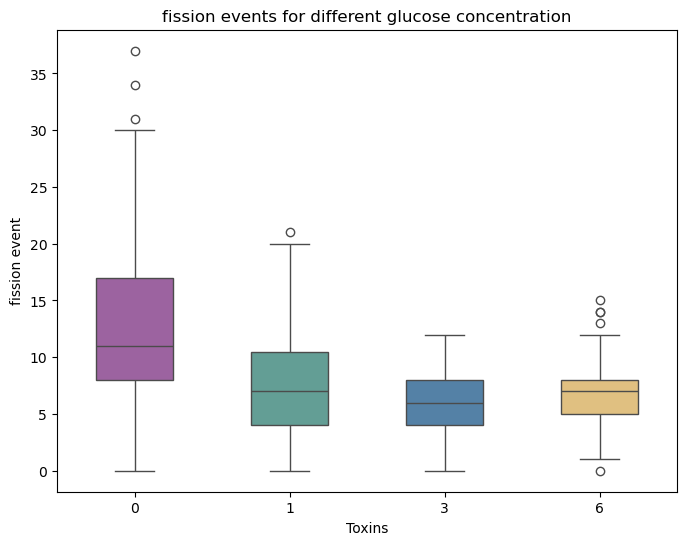

In [87]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [82]:
normality = pg.normality(data = fission_glu_frame, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fission_glu_frame, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_frame, parametric=False,padjust='holm', effsize = 'r'))

                      W      pval  normal
concentration                            
0              0.975133  0.010442   False
1              0.959463  0.000319   False
3              0.985882  0.151516    True
6              0.984319  0.102516    True
                W          pval  equal_var
levene  20.763126  8.901914e-13      False
fission
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False   9746.5   two-sided  0.494733   
1  concentration  0  3   False       False  13407.5   two-sided  0.000005   
2  concentration  0  6   False       False  10631.0   two-sided  0.561538   
3  concentration  1  3   False       False  13324.0   two-sided  0.000009   
4  concentration  1  6   False       False  11105.5   two-sided  0.208001   
5  concentration  3  6   False       False   7054.5   two-sided  0.000006   

     p-corr p-adjust         r  
0  0.989465     holm  0.257300  
1  0.000032     holm -0.045100  
2  0.989465    

C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\713587994.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_frame,  palette=colors, ax=ax, width=0.5)


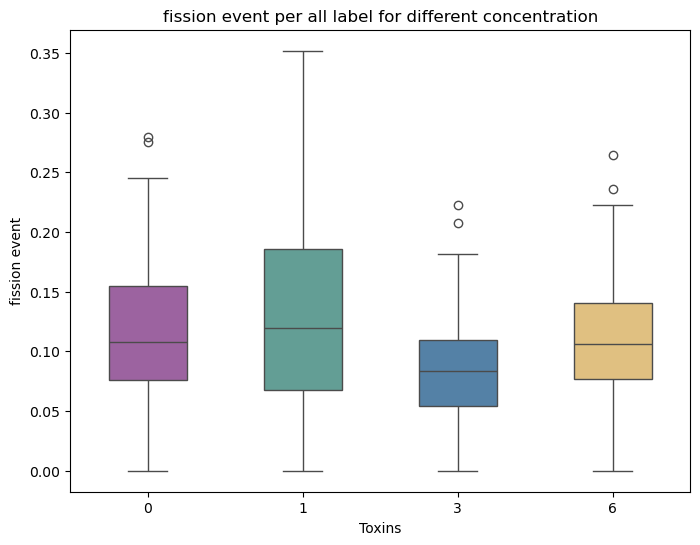

In [85]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [94]:
normality = pg.normality(data = fission_glu_area, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fission_glu_area, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_area, parametric=False,padjust='holm', effsize = 'r'))

                      W          pval  normal
concentration                                
0              0.914999  1.794187e-07   False
1              0.905335  4.827258e-08   False
3              0.987547  2.277968e-01    True
6              0.985686  1.443092e-01    True
               W      pval  equal_var
levene  9.919808  0.000002      False
fission
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  11422.0   two-sided  8.696624e-02   
1  concentration  0  3   False       False  11111.0   two-sided  2.051852e-01   
2  concentration  0  6   False       False   7618.0   two-sided  1.942420e-04   
3  concentration  1  3   False       False   9968.0   two-sided  7.143193e-01   
4  concentration  1  6   False       False   7060.5   two-sided  6.080455e-06   
5  concentration  3  6   False       False   6209.0   two-sided  9.403196e-09   

         p-corr p-adjust         r  
0  2.608987e-01     holm  0.199040 

C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3115319762.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_area,  palette=colors, ax=ax, width=0.5)


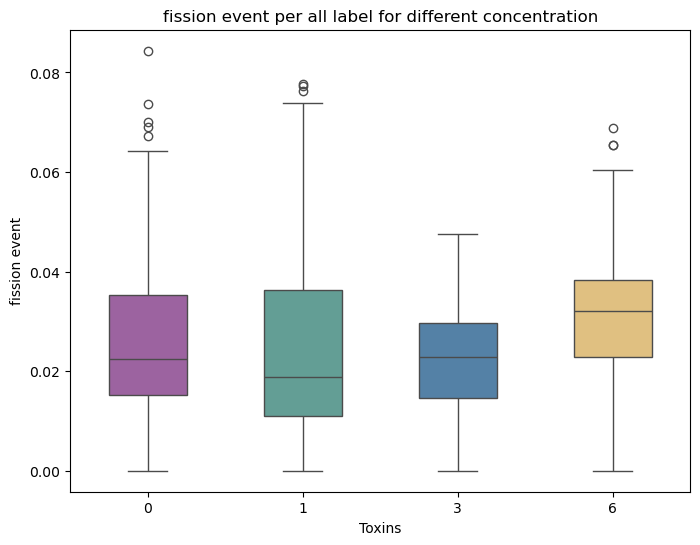

In [95]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fusion, fusion/area, fusion/all label

In [89]:
normality = pg.normality(data = fusion_glu_pd, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fusion_glu_pd, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_pd, parametric=False,padjust='holm', effsize = 'r'))

                      W          pval  normal
concentration                                
0              0.886385  4.575938e-09   False
1              0.895527  1.379838e-08   False
3              0.955012  1.307407e-04   False
6              0.977989  2.096626e-02   False
                W          pval  equal_var
levene  47.226155  2.925882e-27      False
fission
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  13822.5   two-sided  2.548163e-07   
1  concentration  0  3   False       False  14108.5   two-sided  2.486331e-08   
2  concentration  0  6   False       False  13549.0   two-sided  1.870334e-06   
3  concentration  1  3   False       False   9909.5   two-sided  6.515948e-01   
4  concentration  1  6   False       False   9292.5   two-sided  1.813734e-01   
5  concentration  3  6   False       False   9000.5   two-sided  7.806969e-02   

         p-corr p-adjust         r  
0  1.274082e-06     holm 

C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\57580432.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_pd,  palette=colors, ax=ax, width=0.5)


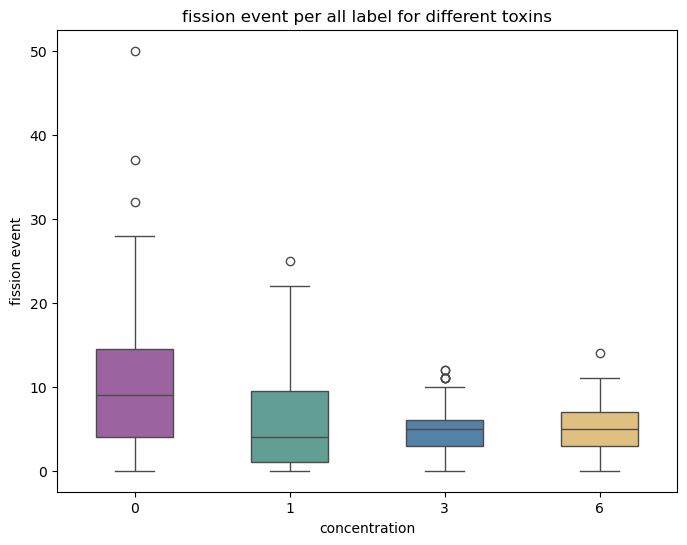

In [91]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="concentration", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [93]:
print("adjusted fusion") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_frame, parametric=False, padjust='holm',effsize = 'r'))

adjusted fusion
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  10280.5   two-sided  0.936731   
1  concentration  0  3   False       False  11602.5   two-sided  0.048865   
2  concentration  0  6   False       False   9779.5   two-sided  0.525030   
3  concentration  1  3   False       False  11224.5   two-sided  0.152814   
4  concentration  1  6   False       False   9794.0   two-sided  0.538554   
5  concentration  3  6   False       False   7632.5   two-sided  0.000211   

     p-corr p-adjust         r  
0  1.000000     holm  0.127278  
1  0.244323     holm  0.020599  
2  1.000000     holm  0.032812  
3  0.611255     holm  0.108707  
4  1.000000     holm -0.092267  
5  0.001264     holm  0.057399  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\729057569.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_frame,  palette=colors, ax=ax, width=0.5)


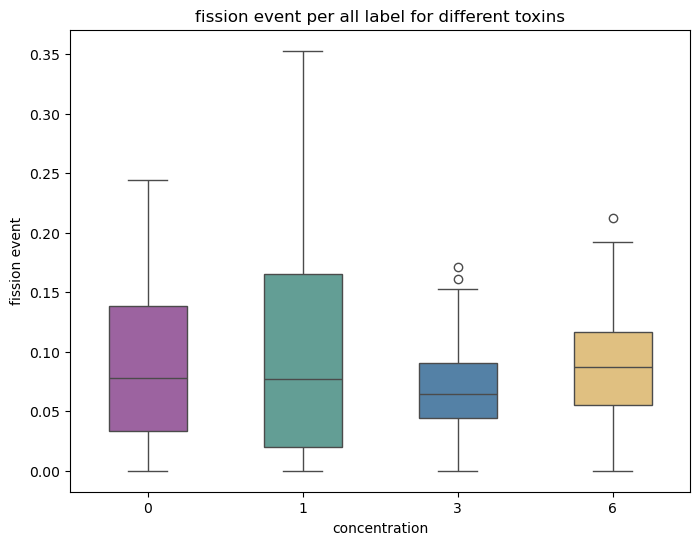

In [92]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="concentration", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission event per all label for different toxins")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [96]:
normality = pg.normality(data = fusion_glu_area, dv = 'event', group = 'concentration')
homogeneity = pg.homoscedasticity(data = fusion_glu_area, dv = 'event', group = 'concentration')
print(normality)
print(homogeneity)

print("fission") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_area, parametric=False,padjust='holm', effsize = 'r'))

                      W          pval  normal
concentration                                
0              0.889224  6.407396e-09   False
1              0.912201  1.216142e-07   False
3              0.967640  1.832379e-03   False
6              0.985822  1.492717e-01    True
                W      pval  equal_var
levene  10.363695  0.000001      False
fission
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  11630.5   two-sided  4.440813e-02   
1  concentration  0  3   False       False  10105.5   two-sided  8.654442e-01   
2  concentration  0  6   False       False   7304.0   two-sided  2.974690e-05   
3  concentration  1  3   False       False   8817.5   two-sided  4.424261e-02   
4  concentration  1  6   False       False   6491.0   two-sided  9.347653e-08   
5  concentration  3  6   False       False   6830.0   two-sided  1.214819e-06   

         p-corr p-adjust         r  
0  1.327278e-01     holm  0.15272

C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\669948482.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_area,  palette=colors, ax=ax, width=0.5)


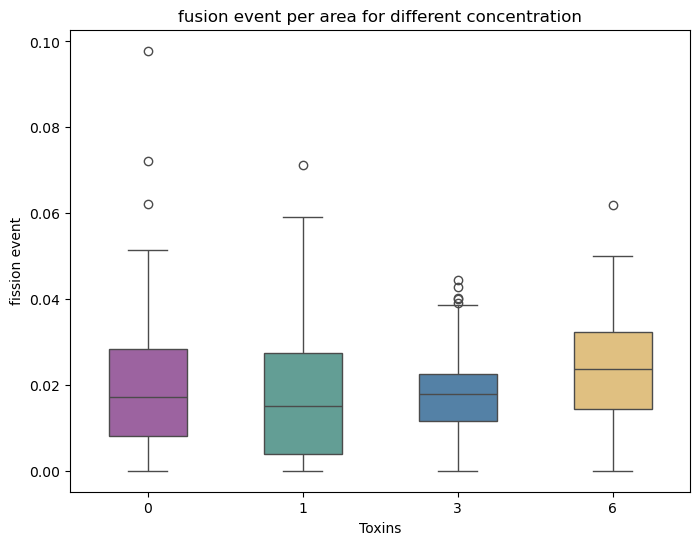

In [97]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fusion event per area for different concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### self_fission, fission/area, fission/label

In [103]:
fission_glu_self_frame = fission_glu_self_pd.copy()
fission_glu_self_area = fission_glu_self_pd.copy()
fission_glu_self_frame['event'] = fission_glu_self_frame['event'] / np.ravel(np.array(label_num_all))
fission_glu_self_area['event'] = fission_glu_self_area['event'] / np.ravel(np.array(area_all))

fusion_glu_self_frame = fusion_glu_self_pd.copy()
fusion_glu_self_area = fusion_glu_self_pd.copy()
fusion_glu_self_frame['event'] = fusion_glu_self_frame['event'] / np.ravel(np.array(label_num_all))
fusion_glu_self_area['event'] = fusion_glu_self_area['event'] / np.ravel(np.array(area_all))

In [99]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fission all
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  15428.5   two-sided  9.205587e-14   
1  concentration  0  3   False       False  17227.5   two-sided  1.152978e-23   
2  concentration  0  6   False       False  17534.0   two-sided  1.242980e-25   
3  concentration  1  3   False       False  12456.5   two-sided  1.380097e-03   
4  concentration  1  6   False       False  13091.5   two-sided  3.977658e-05   
5  concentration  3  6   False       False  11144.5   two-sided  1.871079e-01   

         p-corr p-adjust         r  
0  3.682235e-13     holm  0.268069  
1  5.764892e-23     holm  0.059807  
2  7.457883e-25     holm  0.297033  
3  2.760194e-03     holm  0.261977  
4  1.193298e-04     holm  0.204517  
5  1.871079e-01     holm  0.162525  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\1891353390.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_pd,  palette=colors, ax=ax, width=0.5)


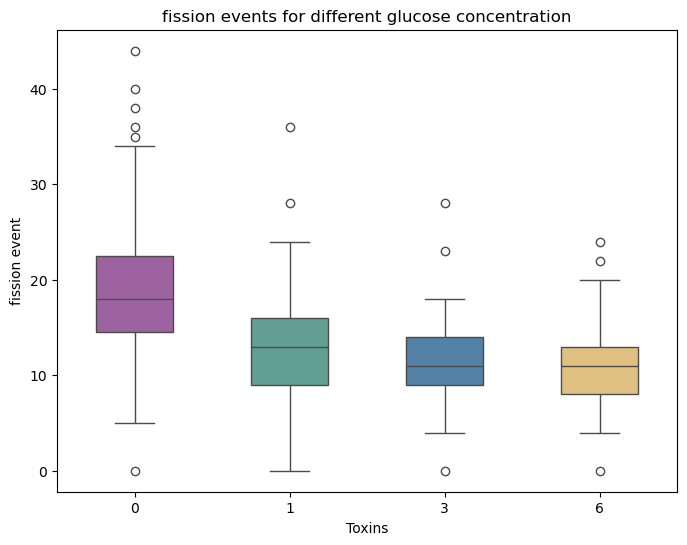

In [104]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [105]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_self_frame, parametric=False,padjust='holm', effsize = 'r'))

fission all
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False   6146.5   two-sided  5.521489e-09   
1  concentration  0  3   False       False  11656.0   two-sided  4.072965e-02   
2  concentration  0  6   False       False  10005.0   two-sided  7.541596e-01   
3  concentration  1  3   False       False  15199.5   two-sided  1.132254e-12   
4  concentration  1  6   False       False  14066.5   two-sided  3.946403e-08   
5  concentration  3  6   False       False   8629.0   two-sided  2.255953e-02   

         p-corr p-adjust         r  
0  2.760745e-08     holm  0.232366  
1  8.145929e-02     holm  0.119574  
2  7.541596e-01     holm  0.229666  
3  6.793525e-12     holm  0.210160  
4  1.578561e-07     holm  0.126275  
5  6.767858e-02     holm  0.215435  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\2791038107.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_frame,  palette=colors, ax=ax, width=0.5)


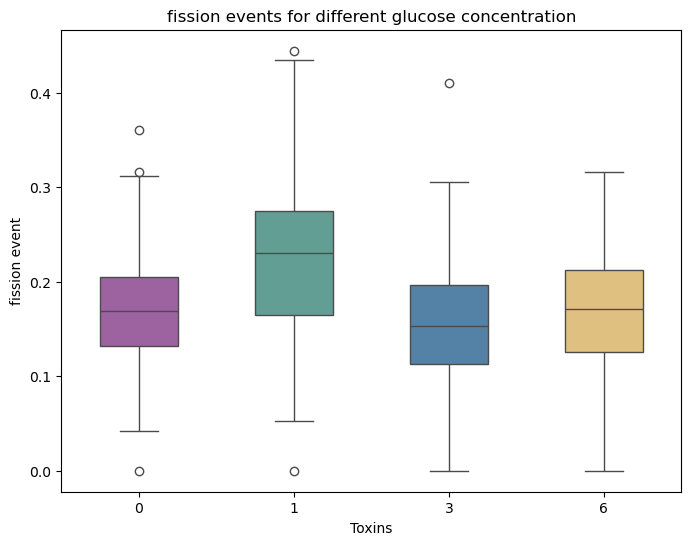

In [106]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [107]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_self_area, parametric=False,padjust='holm', effsize = 'r'))

fission all
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False   9057.5   two-sided  9.531390e-02   
1  concentration  0  3   False       False   8368.5   two-sided  7.972588e-03   
2  concentration  0  6   False       False   6359.5   two-sided  3.277062e-08   
3  concentration  1  3   False       False  10167.5   two-sided  9.356083e-01   
4  concentration  1  6   False       False   8080.5   two-sided  2.176356e-03   
5  concentration  3  6   False       False   7840.0   two-sided  6.521462e-04   

         p-corr p-adjust         r  
0  1.906278e-01     holm  0.250481  
1  2.391776e-02     holm  0.014052  
2  1.966237e-07     holm  0.284448  
3  9.356083e-01     holm  0.231683  
4  8.705423e-03     holm  0.191218  
5  3.260731e-03     holm  0.157496  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3422194935.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_area,  palette=colors, ax=ax, width=0.5)


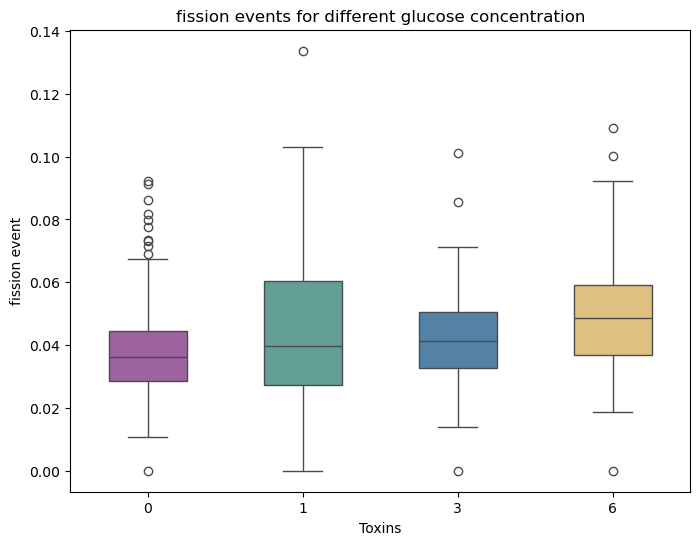

In [108]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_self_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### self fusion, fusion/area, fusion/label

In [109]:
print("fusion all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_self_pd, parametric=False,padjust='holm', effsize = 'r'))

fusion all
        Contrast  A  B  Paired  Parametric    U-val alternative         p-unc  \
0  concentration  0  1   False       False  15917.5   two-sided  3.496230e-16   
1  concentration  0  3   False       False  17007.0   two-sided  2.551572e-22   
2  concentration  0  6   False       False  17610.0   two-sided  3.706071e-26   
3  concentration  1  3   False       False  11631.0   two-sided  4.361818e-02   
4  concentration  1  6   False       False  12812.0   two-sided  2.066962e-04   
5  concentration  3  6   False       False  11546.5   two-sided  5.784630e-02   

         p-corr p-adjust         r  
0  1.398492e-15     holm  0.206171  
1  1.275786e-21     holm  0.010894  
2  2.223642e-25     holm  0.253356  
3  8.723636e-02     holm  0.115264  
4  6.200887e-04     holm  0.141103  
5  8.723636e-02     holm  0.036804  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3879027562.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_pd,  palette=colors, ax=ax, width=0.5)


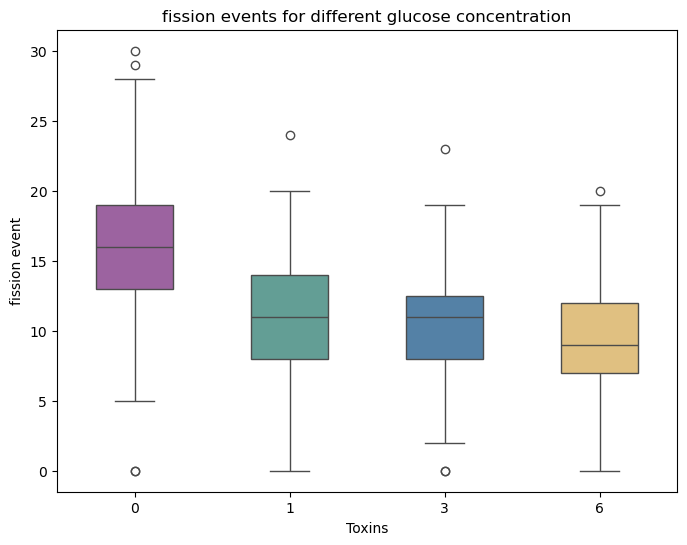

In [110]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [ ]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_self_frame, parametric=False,padjust='holm', effsize = 'r'))

C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3223939047.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_frame,  palette=colors, ax=ax, width=0.5)


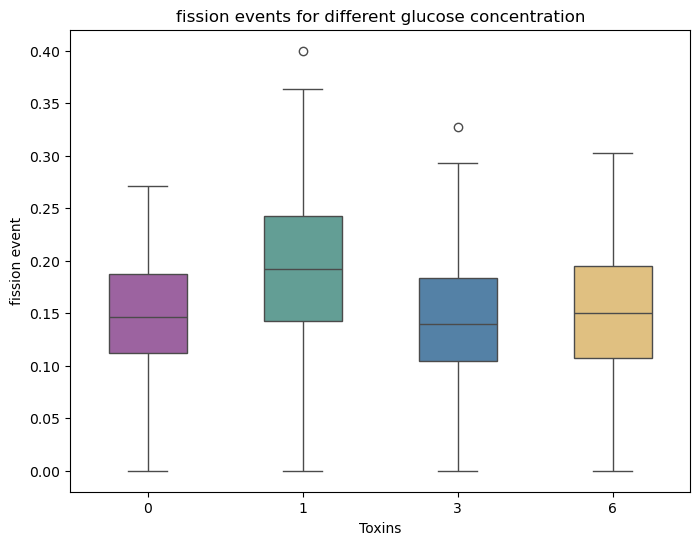

In [111]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_frame,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [112]:
print("fission all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_self_area, parametric=False,padjust='holm', effsize = 'r'))

fission all
        Contrast  A  B  Paired  Parametric   U-val alternative         p-unc  \
0  concentration  0  1   False       False  8947.0   two-sided  6.784753e-02   
1  concentration  0  3   False       False  7730.0   two-sided  3.621389e-04   
2  concentration  0  6   False       False  6078.0   two-sided  3.057469e-09   
3  concentration  1  3   False       False  8984.0   two-sided  7.621035e-02   
4  concentration  1  6   False       False  7172.0   two-sided  1.276232e-05   
5  concentration  3  6   False       False  8130.0   two-sided  2.751026e-03   

         p-corr p-adjust         r  
0  1.356951e-01     holm  0.170884  
1  1.448556e-03     holm  0.012363  
2  1.834481e-08     holm  0.242886  
3  1.356951e-01     holm  0.121239  
4  6.381161e-05     holm  0.079065  
5  8.253077e-03     holm  0.037862  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3423921821.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_area,  palette=colors, ax=ax, width=0.5)


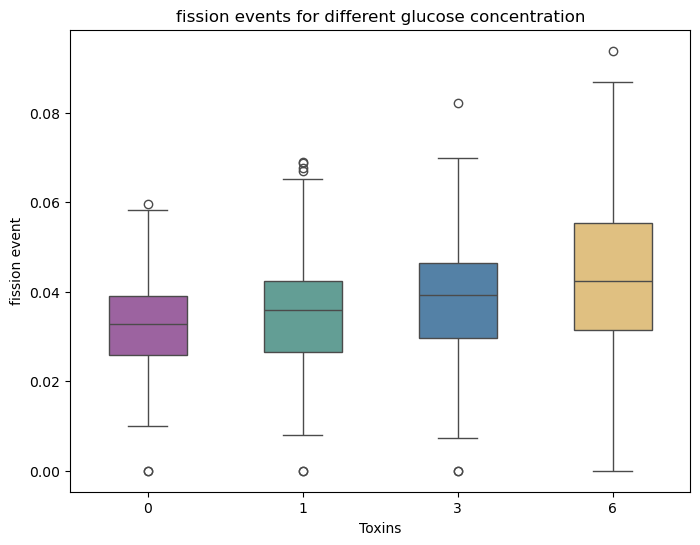

In [113]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_self_area,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fission fusion from nellie

In [116]:
print("fission nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fission_glu_nellie_pd, parametric=False,padjust='holm', effsize = 'r'))

fission nellie
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  11013.5   two-sided  0.228742   
1  concentration  0  3   False       False  11598.0   two-sided  0.034684   
2  concentration  0  6   False       False  11612.0   two-sided  0.033708   
3  concentration  1  3   False       False  10897.5   two-sided  0.294293   
4  concentration  1  6   False       False  10898.5   two-sided  0.296166   
5  concentration  3  6   False       False  10247.0   two-sided  0.972529   

     p-corr p-adjust         r  
0  0.914966     holm  0.044157  
1  0.202246     holm -0.116640  
2  0.202246     holm  0.269143  
3  0.914966     holm  0.025193  
4  0.914966     holm  0.128321  
5  0.972529     holm  0.004850  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3057658906.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fission_glu_nellie_pd,  palette=colors, ax=ax, width=0.5)


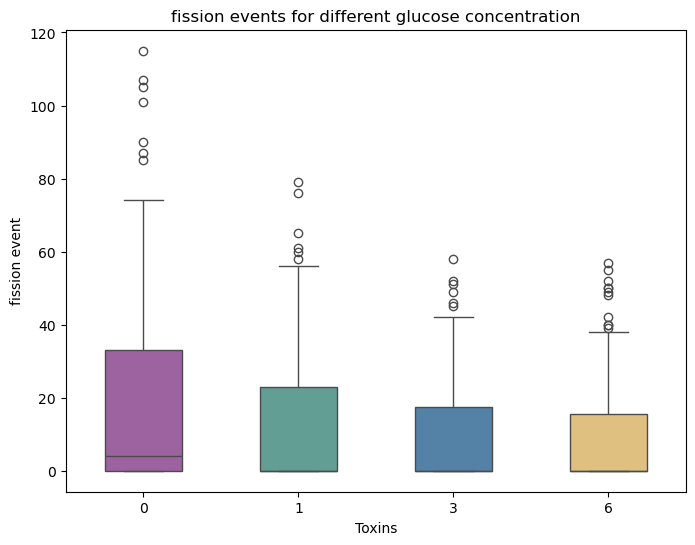

In [117]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fission_glu_nellie_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [119]:
print("fusion nellie") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = fusion_glu_nellie_pd, parametric=False,padjust='holm', effsize = 'r'))

fusion nellie
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  10211.0   two-sided  0.984020   
1  concentration  0  3   False       False  10447.5   two-sided  0.732966   
2  concentration  0  6   False       False  10645.5   two-sided  0.517070   
3  concentration  1  3   False       False  10641.5   two-sided  0.528933   
4  concentration  1  6   False       False  10954.5   two-sided  0.268182   
5  concentration  3  6   False       False  10506.5   two-sided  0.670429   

   p-corr p-adjust         r  
0     1.0     holm  0.100410  
1     1.0     holm -0.046956  
2     1.0     holm  0.140746  
3     1.0     holm -0.115067  
4     1.0     holm  0.029757  
5     1.0     holm -0.010674  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3048999664.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_nellie_pd,  palette=colors, ax=ax, width=0.5)


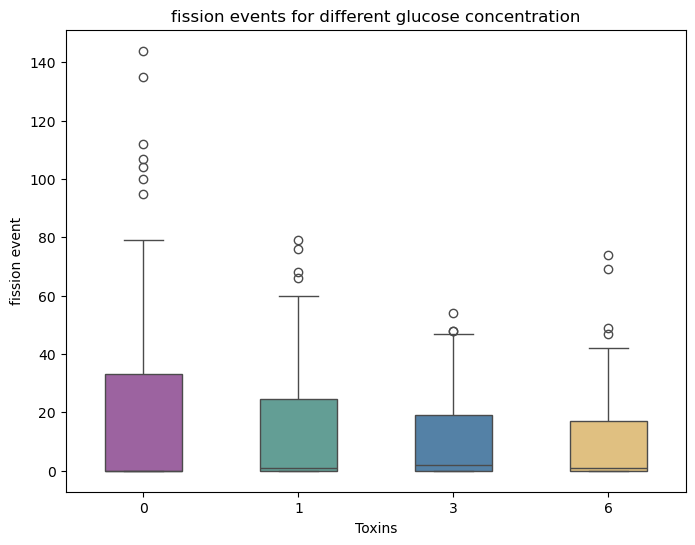

In [120]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=fusion_glu_nellie_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission events for different glucose concentration")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

#### fission / fusion ratio

In [148]:
print("fission fusion ratio") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = ff_ratio_log_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  10411.0   two-sided  0.790246   
1  concentration  0  3   False       False  11051.0   two-sided  0.237475   
2  concentration  0  6   False       False  10799.5   two-sided  0.411290   
3  concentration  1  3   False       False  10786.0   two-sided  0.422310   
4  concentration  1  6   False       False  10618.0   two-sided  0.574041   
5  concentration  3  6   False       False  10100.5   two-sided  0.859763   

   p-corr p-adjust         r  
0     1.0     holm  0.161520  
1     1.0     holm -0.096870  
2     1.0     holm -0.006586  
3     1.0     holm  0.024004  
4     1.0     holm -0.087851  
5     1.0     holm  0.069880  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\2452327688.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_log_pd,  palette=colors, ax=ax, width=0.5)


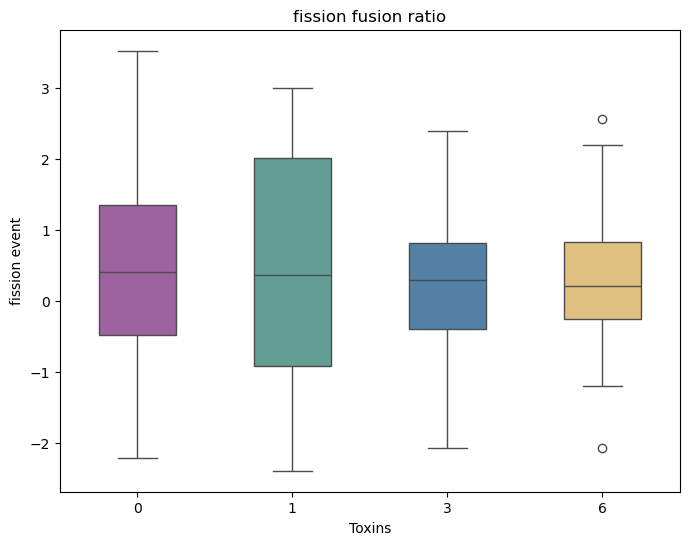

In [149]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_log_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [150]:
print("fission fusion ratio adjusted") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = ff_ratio_all_log_pd, parametric=False,padjust='holm', effsize = 'r'))

fission fusion ratio adjusted
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  10239.0   two-sided  0.984028   
1  concentration  0  3   False       False  10719.0   two-sided  0.479933   
2  concentration  0  6   False       False  10568.5   two-sided  0.623282   
3  concentration  1  3   False       False  10693.0   two-sided  0.503340   
4  concentration  1  6   False       False  10485.0   two-sided  0.710035   
5  concentration  3  6   False       False   9976.5   two-sided  0.723379   

   p-corr p-adjust         r  
0     1.0     holm  0.099015  
1     1.0     holm -0.209089  
2     1.0     holm  0.193354  
3     1.0     holm  0.145566  
4     1.0     holm  0.040451  
5     1.0     holm  0.016646  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\2945083622.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_all_log_pd,  palette=colors, ax=ax, width=0.5)


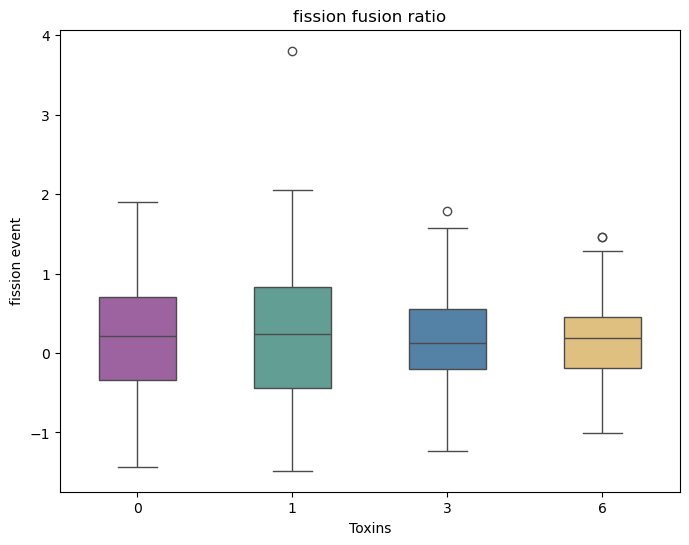

In [151]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_all_log_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()

In [152]:
print("fission fusion ratio all") # shows all of then are significantly different 
#check the influence and correlation with Rank Biserial Correlation
print(pg.pairwise_tests(dv = 'event', between =  'concentration', data = ff_ratio_self_log_pd, parametric=False, padjust='holm' ,effsize = 'r' ))

fission fusion ratio all
        Contrast  A  B  Paired  Parametric    U-val alternative     p-unc  \
0  concentration  0  1   False       False  10152.5   two-sided  0.918561   
1  concentration  0  3   False       False  10551.5   two-sided  0.640551   
2  concentration  0  6   False       False  10327.0   two-sided  0.884030   
3  concentration  1  3   False       False  10579.0   two-sided  0.612669   
4  concentration  1  6   False       False  10371.0   two-sided  0.834614   
5  concentration  3  6   False       False  10044.0   two-sided  0.796845   

   p-corr p-adjust         r  
0     1.0     holm  0.216176  
1     1.0     holm  0.063730  
2     1.0     holm  0.351199  
3     1.0     holm  0.171919  
4     1.0     holm  0.183401  
5     1.0     holm  0.140371  


C:\Users\iceji\AppData\Local\Temp\ipykernel_25568\3911165905.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_self_log_pd,  palette=colors, ax=ax, width=0.5)


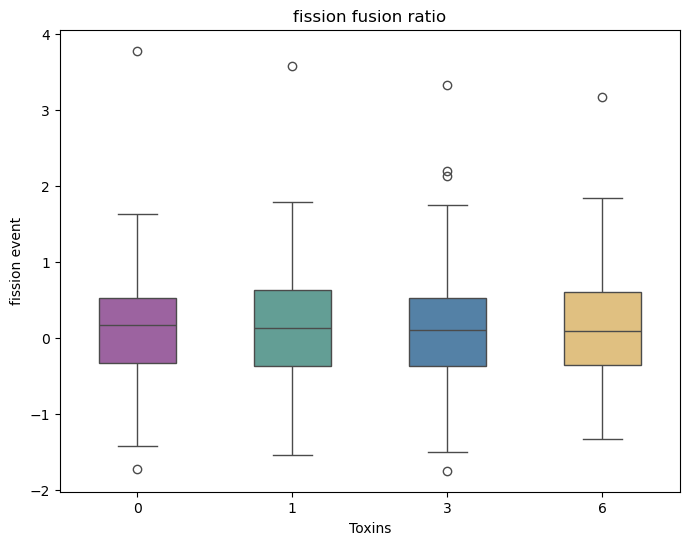

In [153]:
import seaborn as sns

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)

# Define colors for boxes
colors = ['#a559aa', '#59a89c', '#4682b4', '#f0c571']

# Create boxplot with Seaborn
bp = sns.boxplot(x='concentration', y='event', data=ff_ratio_self_log_pd,  palette=colors, ax=ax, width=0.5)
ax.set(xlabel="Toxins", ylabel="fission event")

# Customize fliers (outliers)
for flier in ax.collections:  # Fliers are stored as PathCollection
    flier.set(marker='D', color='#e7298a', alpha=0.5)

# Set title and axis ticks
plt.title("fission fusion ratio")
ax.tick_params(axis='x', bottom=True)
ax.tick_params(axis='y', left=True)

# Show plot
plt.show()